Importation des bibliothèques et des modules nécessaires

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam as LegacyAdam
from keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math

Configuration de l'utilisation de la carte graphique

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU detected. Please ensure you have the GPU version of TensorFlow installed.")

No GPU detected. Please ensure you have the GPU version of TensorFlow installed.


Chargement des données

In [3]:
data_dir = 'chest_Xray'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

Préparation des générateurs de données

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', subset='training', color_mode='grayscale')
val_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', subset='validation', color_mode='grayscale')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False, color_mode='grayscale')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Réseau de neurones convolutifs (CNN) simple

Construction du modèle

In [5]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

Compilation et entraînement du modèle avec validation croisée

In [6]:
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
fold = 1

indices = np.arange(train_generator.samples)

for train_index, val_index in kfold.split(indices, train_generator.classes):
    model = create_model()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    print(f"Fold {fold} Training...")
    history = model.fit(train_generator,
                        steps_per_epoch=len(train_index) // train_generator.batch_size,
                        epochs=10,
                        validation_data=val_generator,
                        validation_steps=len(val_index) // val_generator.batch_size)
    fold += 1

Fold 1 Training...
Epoch 1/10
104/104 [==============================] - 132s 1s/step - loss: 0.2691 - accuracy: 0.8824 - val_loss: 0.1396 - val_accuracy: 0.9483
Epoch 2/10
104/104 [==============================] - 110s 1s/step - loss: 0.1171 - accuracy: 0.9573 - val_loss: 0.1449 - val_accuracy: 0.9495
Epoch 3/10
104/104 [==============================] - 100s 960ms/step - loss: 0.1006 - accuracy: 0.9665 - val_loss: 0.1538 - val_accuracy: 0.9423
Epoch 4/10
104/104 [==============================] - 100s 965ms/step - loss: 0.0852 - accuracy: 0.9689 - val_loss: 0.1325 - val_accuracy: 0.9639
Epoch 5/10
104/104 [==============================] - 100s 961ms/step - loss: 0.0647 - accuracy: 0.9731 - val_loss: 0.1300 - val_accuracy: 0.9603
Epoch 6/10
104/104 [==============================] - 99s 955ms/step - loss: 0.0562 - accuracy: 0.9810 - val_loss: 0.1606 - val_accuracy: 0.9483
Epoch 7/10
104/104 [==============================] - 100s 959ms/step - loss: 0.0385 - accuracy: 0.9846 - val_lo

Évaluation du modèle

In [7]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy: ", test_acc)

20/20 [==============================] - 6s 292ms/step - loss: 1.5522 - accuracy: 0.7676
Test Accuracy:  0.7676281929016113


Prédictions et résultats

In [8]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

20/20 [==============================] - 5s 234ms/step


Affichage du rapport de classification et de la matrice de confusion

In [9]:
print(classification_report(y_true, y_pred_classes))
print(confusion_matrix(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      0.38      0.55       234
           1       0.73      1.00      0.84       390

    accuracy                           0.77       624
   macro avg       0.86      0.69      0.70       624
weighted avg       0.83      0.77      0.73       624

[[ 90 144]
 [  1 389]]


Sauvegarde du modèle

In [10]:
model.save('chest_xray_model.h5')

Visualisation des performances du modèle

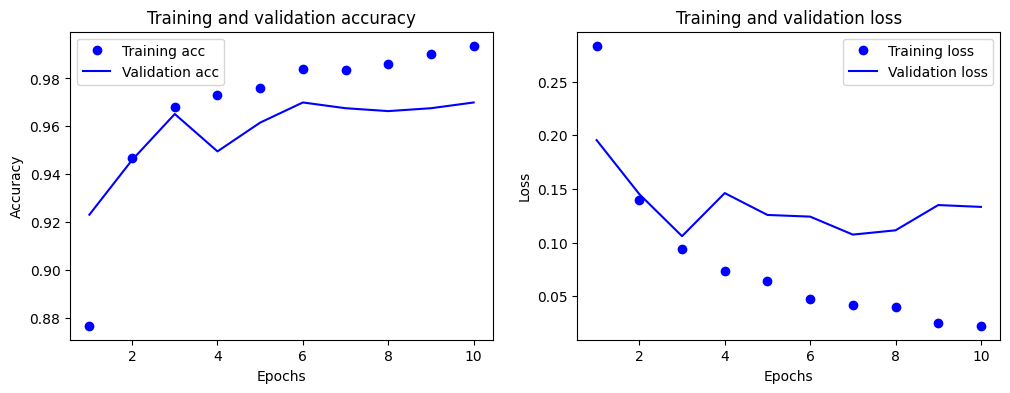

In [11]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

Visualisation de la matrice de confusion

Confusion matrix, without normalization


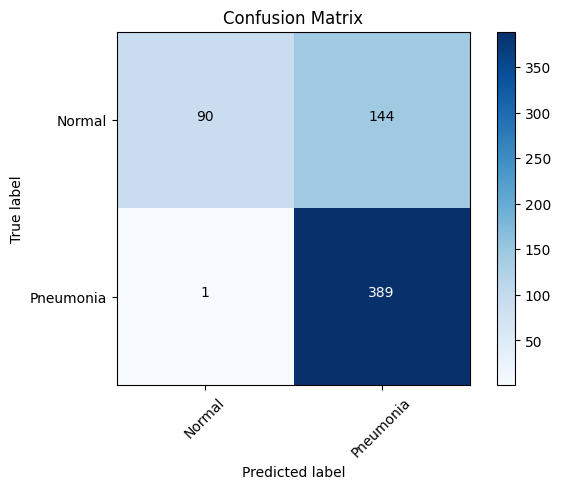

In [12]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=['Normal', 'Pneumonia'])

Visualisation des erreurs de classification

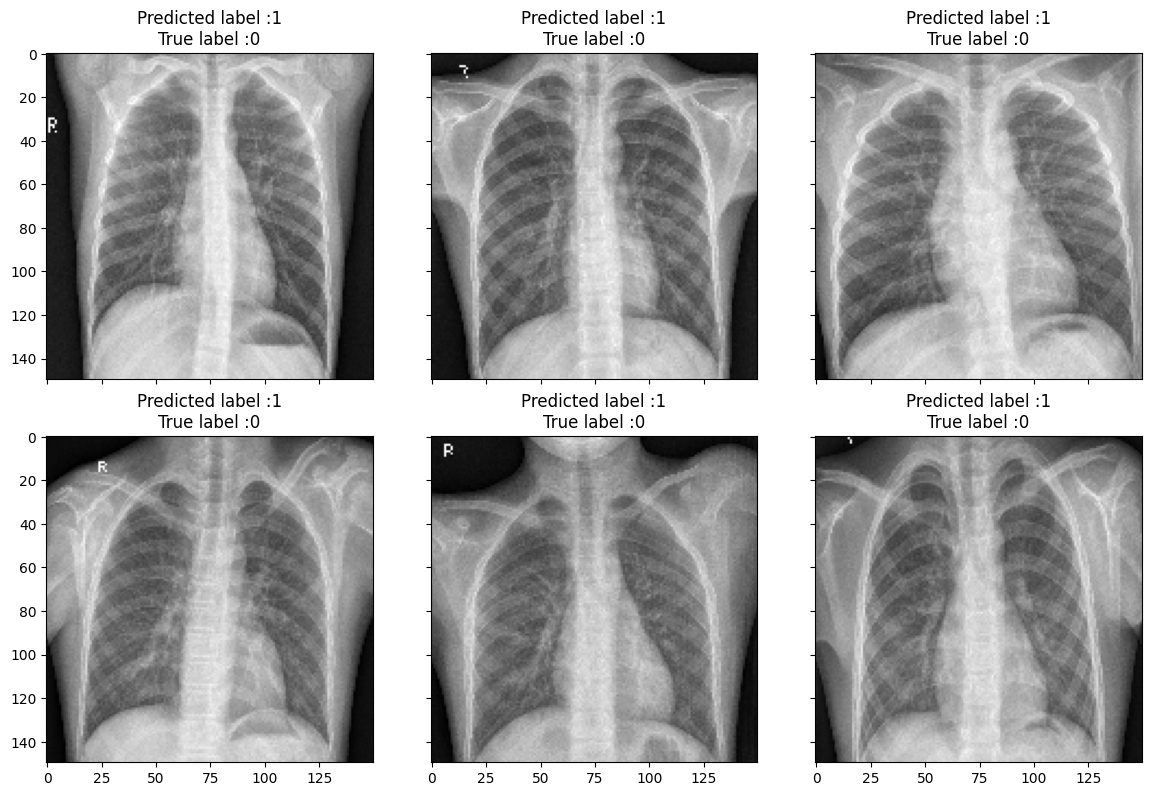

In [13]:
errors = (y_pred_classes != y_true)
X_test, y_test = [], []
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    X_test.extend(X_batch)
    y_test.extend(y_batch)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test_errors = X_test[errors]
y_test_errors = y_test[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors, max_images=6):
    num_errors = min(len(errors_index), max_images)
    ncols = 3
    nrows = math.ceil(num_errors / ncols)
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12, nrows * 4))
    axes = axes.ravel()  # Flatten the axes array
    
    # Hide extra subplots if the number of errors is not a multiple of ncols
    for i in range(num_errors, nrows * ncols):
        axes[i].axis('off')

    for n in range(num_errors):
        axes[n].imshow(img_errors[n].reshape((150, 150)), cmap=plt.cm.gray)
        axes[n].set_title(f"Predicted label :{pred_errors[n]}\nTrue label :{obs_errors[n]}", fontsize=12)
    plt.tight_layout()

y_pred_classes_errors = y_pred_classes[errors]
y_true_errors = y_true[errors]
errors_index = np.nonzero(errors)[0]
display_errors(errors_index, X_test_errors, y_pred_classes_errors, y_true_errors, max_images=6)

Courbe ROC et AUC

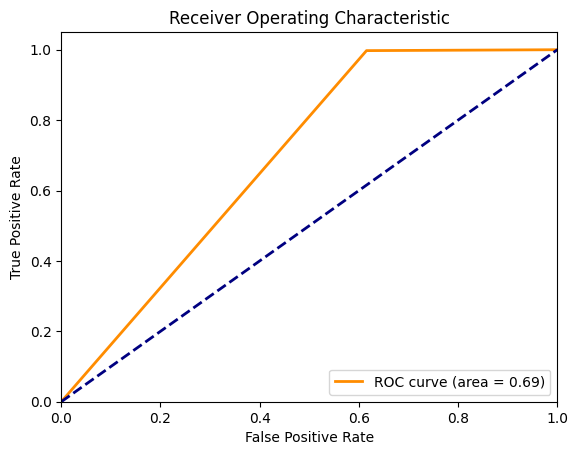

In [14]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Définition de la classe CustomDirectoryIterator

In [15]:
class CustomDirectoryIterator(DirectoryIterator):
    def __init__(self, directory, image_data_generator, target_size=(256, 256),
                 color_mode='grayscale', classes=None, class_mode='categorical',
                 batch_size=32, shuffle=True, seed=None,
                 data_format=None, save_to_dir=None,
                 save_prefix='', save_format='png',
                 follow_links=False, subset=None, interpolation='nearest',
                 keep_aspect_ratio=False, dtype=None):

        # Set default value for classes
        if classes is None:
            classes = []

        super().__init__(directory, image_data_generator, target_size=target_size,
                         color_mode=color_mode, classes=classes, class_mode=class_mode,
                         batch_size=batch_size, shuffle=shuffle, seed=seed,
                         data_format=data_format, save_to_dir=save_to_dir,
                         save_prefix=save_prefix, save_format=save_format,
                         follow_links=follow_links, subset=subset, interpolation=interpolation,
                         keep_aspect_ratio=keep_aspect_ratio, dtype=dtype)


        self.samples = 0

        if len(classes) == 0:
            classes = []
            for subdir in sorted(os.listdir(directory)):
                if os.path.isdir(os.path.join(directory, subdir)):
                    classes.append(subdir)

        self.num_classes = len(classes)
        self.class_indices = dict(zip(classes, range(len(classes))))

Chargement des données et définition des callbacks

In [16]:
data_dir = 'chest_Xray'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
optimizer = LegacyAdam(learning_rate=1e-5)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

Fonction pour charger les données d'images et les labels

In [17]:
def load_data(train_dir):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(train_dir)):
        class_dir = os.path.join(train_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            if img_name == '.DS_Store':
                continue
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Erreur de chargement de l'image : {img_path}")
                continue
            img = cv2.resize(img, (150, 150))
            img = np.expand_dims(img, axis=-1)  # Add an extra dimension for the grayscale channel
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)


Préparation des générateurs de données

In [18]:
X, y = load_data(train_dir)
X = X.astype('float32') / 255

# Préparation des générateurs de données
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                    color_mode='grayscale', batch_size=32,
                                                    class_mode='categorical', subset='training')

val_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                  color_mode='grayscale', batch_size=32,
                                                  class_mode='categorical', subset='validation')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150),
                                                  color_mode='grayscale', batch_size=32,
                                                  class_mode='categorical', shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Réseau de neurones convolutifs (CNN) par apprentissage profond avec validation croisée et augmentation de données pour une meilleure précision

Définition de la fonction de création du modèle

In [19]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(2, activation='softmax'))
    return model

Compilation et entraînement du modèle avec validation croisée

In [20]:
# Compilation et entraînement du modèle avec validation croisée
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
fold = 1

# Créez une liste pour stocker les scores de chaque pli
fold_scores = []

for train_index, val_index in kfold.split(X, y):
    model = create_model()

    # Instantiate a new optimizer for the current fold
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Utilisez les indices de pli pour filtrer les données d'entraînement et de validation
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]

    # Convertir les labels en représentation catégorielle
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

    # Utilisez un générateur avec les index du pli actuel
    train_gen_fold = train_datagen.flow(X_train, y_train, batch_size=32)
    val_gen_fold = train_datagen.flow(X_val, y_val, batch_size=32)

    print(f"Fold {fold} Training...")
    history = model.fit(train_gen_fold,
                        steps_per_epoch=len(train_index) // train_gen_fold.batch_size,
                        epochs=10,
                        validation_data=val_gen_fold,
                        validation_steps=len(val_index) // val_gen_fold.batch_size,
                        callbacks=[early_stopping, lr_scheduler])
    fold += 1
    # Stockez les scores de validation du modèle pour le pli actuel
    fold_scores.append(history.history['val_accuracy'][-1])

Fold 1 Training...
Epoch 1/10
130/130 [==============================] - 129s 988ms/step - loss: 1.5104 - accuracy: 0.7418 - val_loss: 1.4071 - val_accuracy: 0.7441 - lr: 1.0000e-05
Epoch 2/10
130/130 [==============================] - 129s 988ms/step - loss: 1.2911 - accuracy: 0.7553 - val_loss: 1.1730 - val_accuracy: 0.7725 - lr: 1.0000e-05
Epoch 3/10
130/130 [==============================] - 128s 988ms/step - loss: 1.0912 - accuracy: 0.8048 - val_loss: 1.0290 - val_accuracy: 0.8467 - lr: 1.0000e-05
Epoch 4/10
130/130 [==============================] - 128s 987ms/step - loss: 0.9577 - accuracy: 0.8505 - val_loss: 0.8941 - val_accuracy: 0.8652 - lr: 1.0000e-05
Epoch 5/10
130/130 [==============================] - 128s 983ms/step - loss: 0.8735 - accuracy: 0.8570 - val_loss: 0.8342 - val_accuracy: 0.8633 - lr: 1.0000e-05
Epoch 6/10
130/130 [==============================] - 128s 985ms/step - loss: 0.8055 - accuracy: 0.8771 - val_loss: 0.7777 - val_accuracy: 0.8818 - lr: 1.0000e-05
Epo

Calcul de la moyenne des scores de validation

In [21]:
mean_score = np.mean(fold_scores)
print(f"Mean Validation Accuracy: {mean_score}")

Mean Validation Accuracy: 0.90859375


Évaluation du modèle et affichage des résultats

In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy: ", test_acc)

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = test_generator.classes

20/20 [==============================] - 9s 412ms/step - loss: 45.8206 - accuracy: 0.8253
Test Accuracy:  0.8253205418586731
20/20 [==============================] - 9s 397ms/step


Affichage du rapport de classification et de la matrice de confusion

In [23]:
print(classification_report(y_true, y_pred_classes))
print(confusion_matrix(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       234
           1       0.93      0.78      0.85       390

    accuracy                           0.83       624
   macro avg       0.82      0.84      0.82       624
weighted avg       0.85      0.83      0.83       624

[[212  22]
 [ 87 303]]


Sauvegarde du modèle


In [24]:
model.save('chest_xray_model2.h5')

Visualisation des performances du modèle

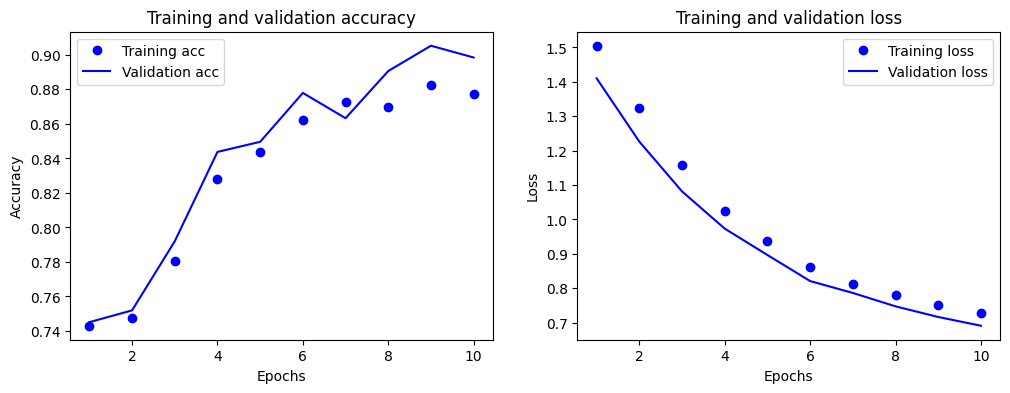

In [25]:
plot_history(history)

Visualisation de la matrice de confusion

Confusion matrix, without normalization


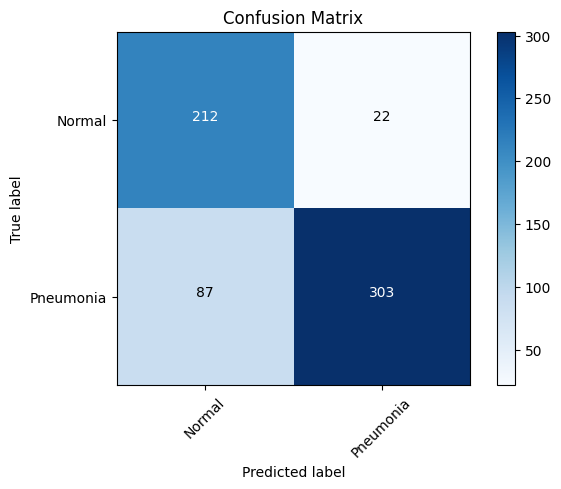

In [26]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=['Normal', 'Pneumonia'])

Visualisation des erreurs de classification

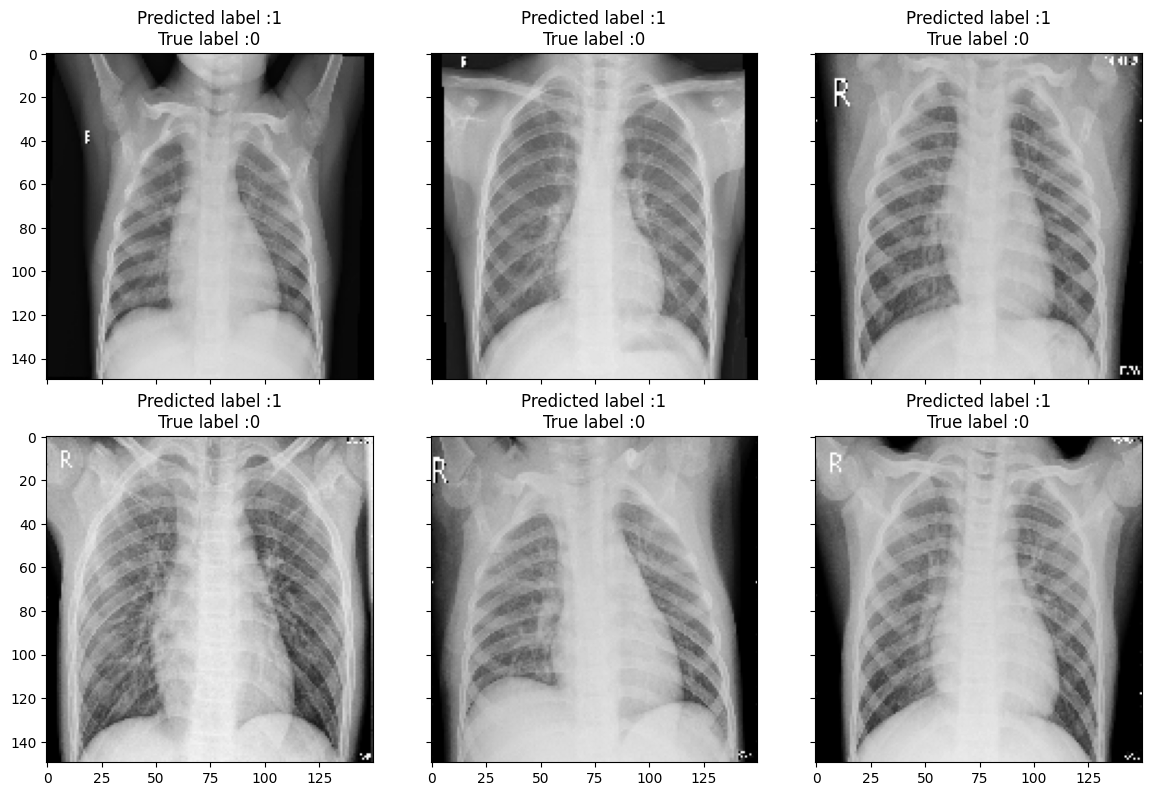

In [27]:
errors = (y_pred_classes != y_true)
X_test, y_test = [], []
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    X_test.extend(X_batch)
    y_test.extend(y_batch)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test_errors = X_test[errors]
y_test_errors = y_test[errors]

y_pred_classes_errors = y_pred_classes[errors]
y_true_errors = y_true[errors]
errors_index = np.nonzero(errors)[0]

# Display errors
display_errors(errors_index, X_test_errors, y_pred_classes_errors, y_true_errors, max_images=6)


Courbe ROC et AUC

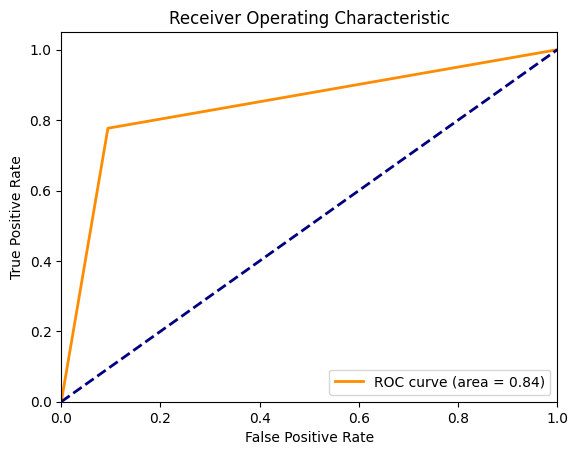

In [28]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Re-Configuration des répertoires et des callbacks

In [29]:
# Chargement des données
data_dir = 'chest_Xray'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

# Définir un callback d'arrêt précoce
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Utiliser un taux d'apprentissage plus faible
optimizer = Adam(learning_rate=1e-5)

# Définir un callback pour réduire le taux d'apprentissage
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

Chargement des données d'images et des labels dans des tableaux Numpy

In [30]:
X, y = load_data(train_dir)
X = X.astype('float32') / 255

Préparation des générateurs de données

In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator()

train_generator = CustomDirectoryIterator(train_dir, train_datagen, target_size=(150, 150),
                                          color_mode='grayscale', batch_size=32,
                                          class_mode='categorical', subset='training')

val_generator = CustomDirectoryIterator(train_dir, train_datagen, target_size=(150, 150),
                                        color_mode='grayscale', batch_size=32,
                                        class_mode='categorical', subset='validation')

test_generator = CustomDirectoryIterator(test_dir, test_datagen, target_size=(150, 150),
                                         color_mode='grayscale', batch_size=32,
                                         class_mode='categorical', shuffle=False)


Found 5216 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Construction du modèle

In [32]:
def replicate_grayscale_channel(x):
    return tf.keras.backend.concatenate([x, x, x], axis=-1)

def create_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    model = Sequential()
    model.add(Input(shape=(150, 150, 1)))
    model.add(Lambda(replicate_grayscale_channel))  # Add the Lambda layer here
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(2, activation='softmax'))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

 Réseau de neurones convolutifs (CNN) DenseNet121 avec augmentation des données et validation croisée pour améliorer la précision

Compilation et entraînement du modèle avec validation croisée

In [33]:
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
fold = 1

# Créez une liste pour stocker les scores de chaque pli
fold_scores = []

for train_index, val_index in kfold.split(X, y):
    model = create_model()

    # Instantiate a new optimizer for the current fold
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Utilisez les indices de pli pour filtrer les données d'entraînement et de validation
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]

    # Convertir les labels en représentation catégorielle
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

    # Utilisez un générateur avec les index du pli actuel
    train_gen_fold = train_datagen.flow(X_train, y_train, batch_size=32)
    val_gen_fold = train_datagen.flow(X_val, y_val, batch_size=32)

    print(f"Fold {fold} Training...")
    history = model.fit(train_gen_fold,
                        steps_per_epoch=len(train_index) // train_gen_fold.batch_size,
                        epochs=10,
                        validation_data=val_gen_fold,
                        validation_steps=len(val_index) // val_gen_fold.batch_size,
                        callbacks=[early_stopping, lr_scheduler])
    fold += 1
    # Stockez les scores de validation du modèle pour le pli actuel
    fold_scores.append(history.history['val_accuracy'][-1])

# Calculez la moyenne des scores de validation pour tous les plis
mean_score = np.mean(fold_scores)
print(f"Mean Validation Accuracy: {mean_score}")

Fold 1 Training...
Epoch 1/10
130/130 [==============================] - 271s 2s/step - loss: 1.4333 - accuracy: 0.6944 - val_loss: 1.1842 - val_accuracy: 0.7441 - lr: 1.0000e-05
Epoch 2/10
130/130 [==============================] - 252s 2s/step - loss: 1.2285 - accuracy: 0.7444 - val_loss: 1.0644 - val_accuracy: 0.8311 - lr: 1.0000e-05
Epoch 3/10
130/130 [==============================] - 242s 2s/step - loss: 1.1143 - accuracy: 0.7961 - val_loss: 0.9691 - val_accuracy: 0.8789 - lr: 1.0000e-05
Epoch 4/10
130/130 [==============================] - 216s 2s/step - loss: 1.0531 - accuracy: 0.8092 - val_loss: 0.9485 - val_accuracy: 0.8633 - lr: 1.0000e-05
Epoch 5/10
130/130 [==============================] - 289s 2s/step - loss: 1.0038 - accuracy: 0.8283 - val_loss: 0.9145 - val_accuracy: 0.8779 - lr: 1.0000e-05
Epoch 6/10
130/130 [==============================] - 282s 2s/step - loss: 0.9382 - accuracy: 0.8498 - val_loss: 0.8897 - val_accuracy: 0.8770 - lr: 1.0000e-05
Epoch 7/10
130/130 [=

Évaluation du modèle

In [34]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy: ", test_acc)

20/20 [==============================] - 86s 4s/step - loss: 3.9749 - accuracy: 0.6266
Test Accuracy:  0.6266025900840759


Prédictions et résultats

In [35]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = test_generator.classes

# Affichage du rapport de classification et de la matrice de confusion
print(classification_report(y_true, y_pred_classes))
print(confusion_matrix(y_true, y_pred_classes))

20/20 [==============================] - 92s 4s/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       234
           1       0.63      1.00      0.77       390

    accuracy                           0.63       624
   macro avg       0.81      0.50      0.39       624
weighted avg       0.77      0.63      0.48       624

[[  1 233]
 [  0 390]]


Sauvegarde du modèle

In [36]:
model.save('chest_xray_model3.h5')

Visualisation des performances du modèle

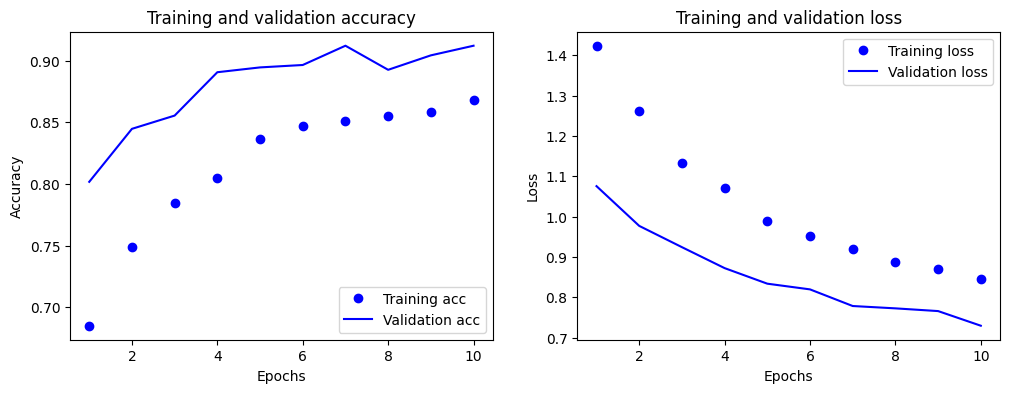

In [37]:
plot_history(history)

Visualisation de la matrice de confusion

Confusion matrix, without normalization


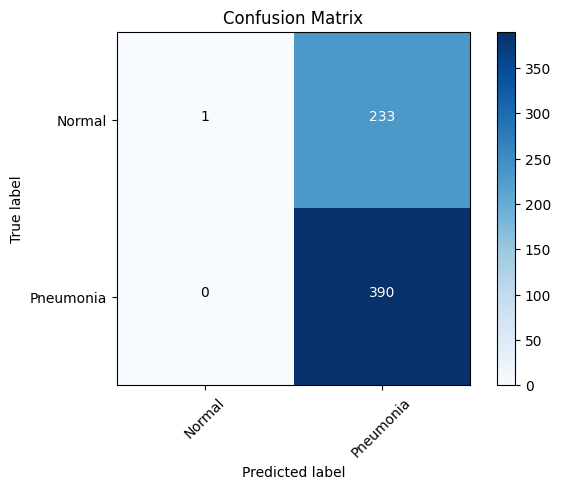

In [38]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=['Normal', 'Pneumonia'])

Visualisation des erreurs de classification

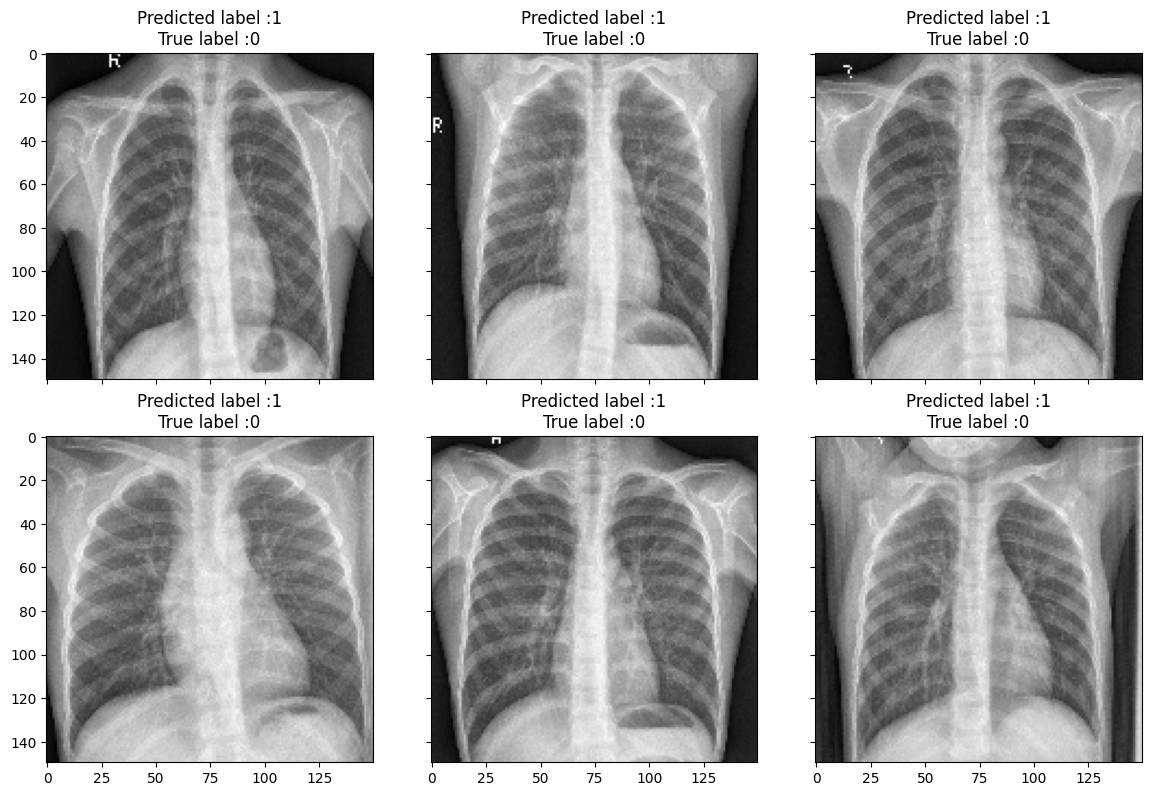

In [39]:
errors = (y_pred_classes != y_true)
X_test, y_test = [], []
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    X_test.extend(X_batch)
    y_test.extend(y_batch)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test_errors = X_test[errors]
y_test_errors = y_test[errors]

y_pred_classes_errors = y_pred_classes[errors]
y_true_errors = y_true[errors]
errors_index = np.nonzero(errors)[0]
display_errors(errors_index, X_test_errors, y_pred_classes_errors, y_true_errors)

Courbe ROC et AUC

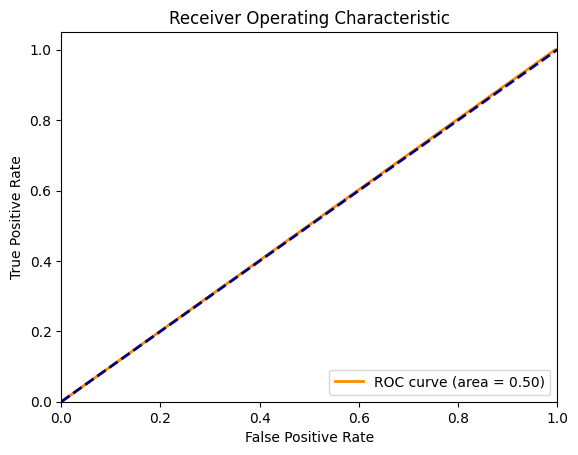

In [40]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Construction du modèle ANN

In [41]:
def create_ann_model():
    model = Sequential()
    model.add(Input(shape=(150, 150, 1)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(2, activation='softmax'))

    return model

Compilation et entraînement du modèle avec validation croisée

In [42]:
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True)
fold = 1

# Créez une liste pour stocker les scores de chaque pli
fold_scores = []

for train_index, val_index in kfold.split(X, y):
    model = create_ann_model()

    # Instantiate a new optimizer for the current fold
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Utilisez les indices de pli pour filtrer les données d'entraînement et de validation
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]

    # Convertir les labels en représentation catégorielle
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

    # Utilisez un générateur avec les index du pli actuel
    train_gen_fold = train_datagen.flow(X_train, y_train, batch_size=32)
    val_gen_fold = train_datagen.flow(X_val, y_val, batch_size=32)

    print(f"Fold {fold} Training...")
    history = model.fit(train_gen_fold,
                        steps_per_epoch=len(train_index) // train_gen_fold.batch_size,
                        epochs=10,
                        validation_data=val_gen_fold,
                        validation_steps=len(val_index) // val_gen_fold.batch_size,
                        callbacks=[early_stopping, lr_scheduler])
    fold += 1
    # Stockez les scores de validation du modèle pour le pli actuel
    fold_scores.append(history.history['val_accuracy'][-1])

# Calculez la moyenne des scores de validation pour tous les plis
mean_score = np.mean(fold_scores)
print(f"Mean Validation Accuracy: {mean_score}")

Fold 1 Training...
Epoch 1/10
130/130 [==============================] - 49s 355ms/step - loss: 2.1074 - accuracy: 0.7109 - val_loss: 2.0064 - val_accuracy: 0.7412 - lr: 1.0000e-05
Epoch 2/10
130/130 [==============================] - 45s 346ms/step - loss: 2.0314 - accuracy: 0.7283 - val_loss: 1.9491 - val_accuracy: 0.7461 - lr: 1.0000e-05
Epoch 3/10
130/130 [==============================] - 48s 370ms/step - loss: 1.9725 - accuracy: 0.7399 - val_loss: 1.8976 - val_accuracy: 0.7607 - lr: 1.0000e-05
Epoch 4/10
130/130 [==============================] - 46s 353ms/step - loss: 1.9154 - accuracy: 0.7483 - val_loss: 1.8517 - val_accuracy: 0.7783 - lr: 1.0000e-05
Epoch 5/10
130/130 [==============================] - 45s 346ms/step - loss: 1.8779 - accuracy: 0.7565 - val_loss: 1.8037 - val_accuracy: 0.7773 - lr: 1.0000e-05
Epoch 6/10
130/130 [==============================] - 46s 349ms/step - loss: 1.8253 - accuracy: 0.7633 - val_loss: 1.7498 - val_accuracy: 0.8213 - lr: 1.0000e-05
Epoch 7/1

Évaluation du modèle

In [43]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy: ", test_acc)

20/20 [==============================] - 7s 328ms/step - loss: 26.8344 - accuracy: 0.7981
Test Accuracy:  0.7980769276618958


Prédictions et résultats

In [44]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = test_generator.classes

# Affichage du rapport de classification et de la matrice de confusion
print(classification_report(y_true, y_pred_classes))
print(confusion_matrix(y_true, y_pred_classes))

20/20 [==============================] - 7s 312ms/step
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       234
           1       0.90      0.76      0.83       390

    accuracy                           0.80       624
   macro avg       0.79      0.81      0.79       624
weighted avg       0.82      0.80      0.80       624

[[201  33]
 [ 93 297]]


Sauvegarde du modèle

In [45]:
model.save('chest_xray_model4.h5')

Visualisation des performances du modèle

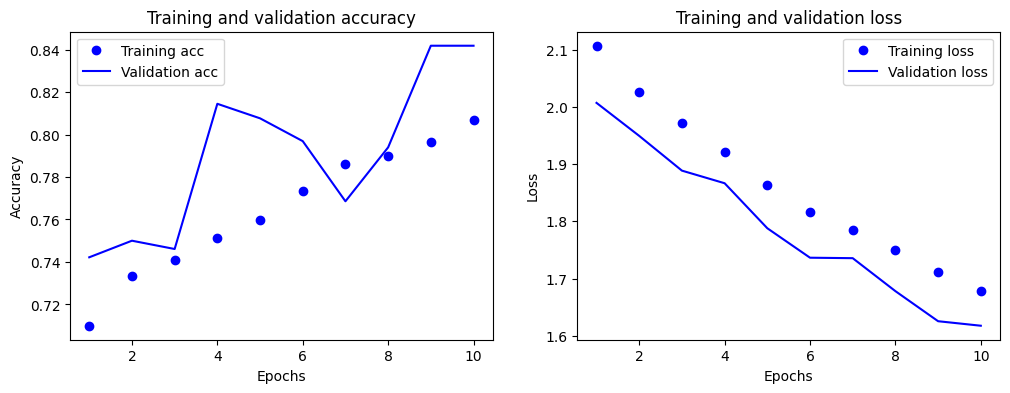

In [46]:
plot_history(history)

Visualisation de la matrice de confusion

Confusion matrix, without normalization


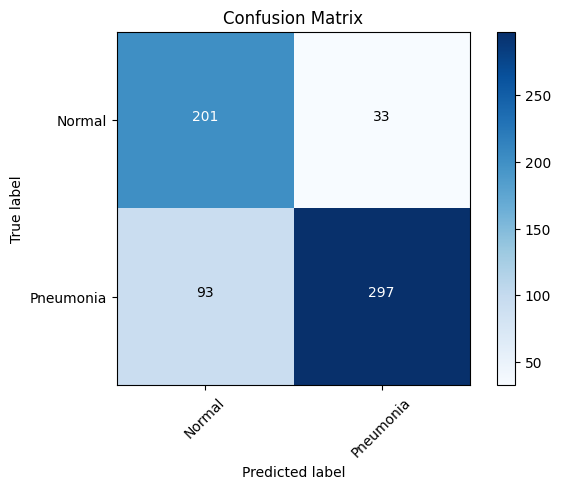

In [47]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=['Normal', 'Pneumonia'])

Visualisation des erreurs de classification

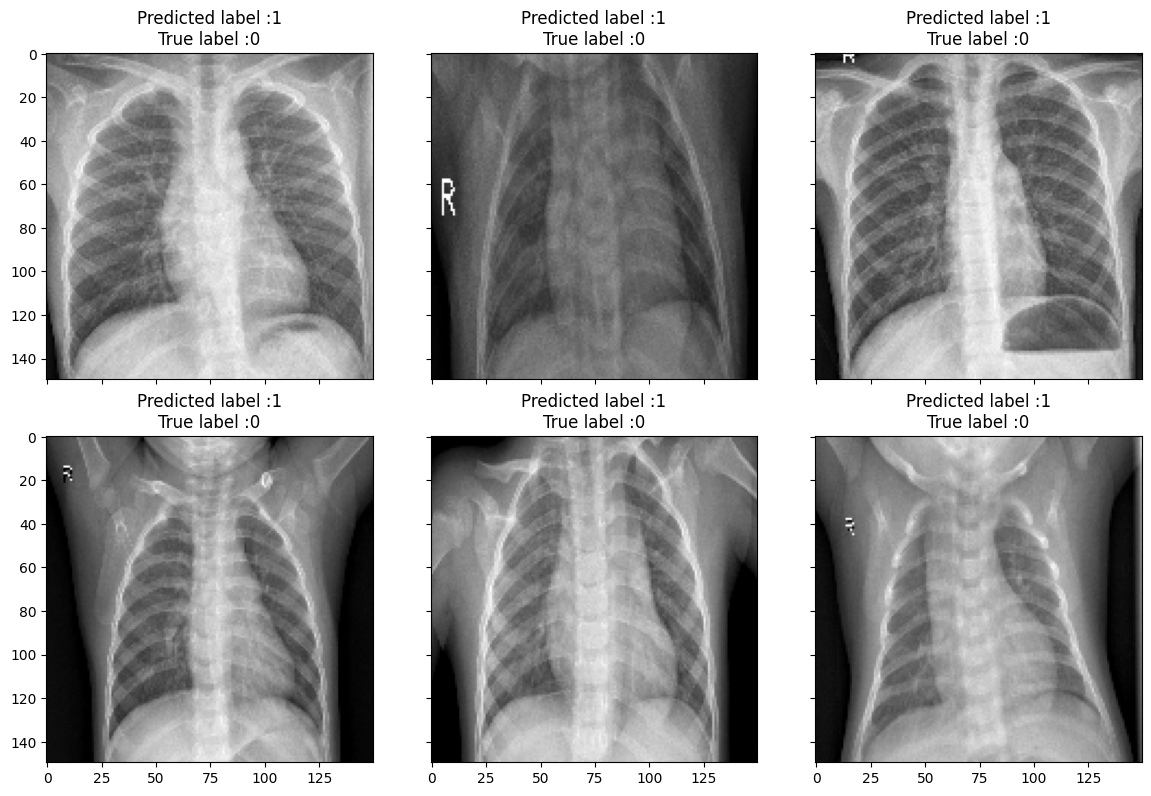

In [48]:
errors = (y_pred_classes != y_true)
X_test, y_test = [], []
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    X_test.extend(X_batch)
    y_test.extend(y_batch)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test_errors = X_test[errors]
y_test_errors = y_test[errors]

y_pred_classes_errors = y_pred_classes[errors]
y_true_errors = y_true[errors]
errors_index = np.nonzero(errors)[0]
display_errors(errors_index, X_test_errors, y_pred_classes_errors, y_true_errors)

Courbe ROC et AUC

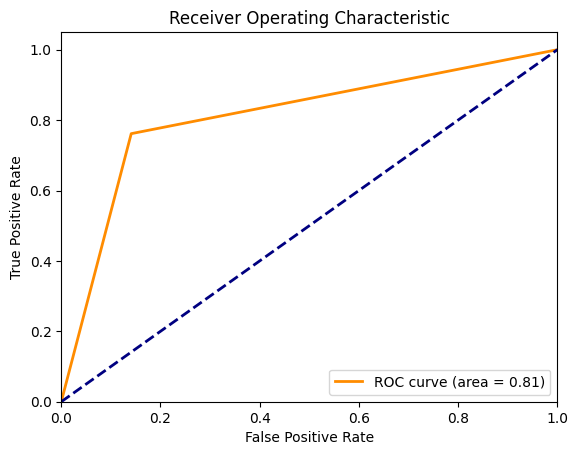

In [49]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Modèles de classification des radiographies pulmonaires

Dans ce Notebook, nous avons entraîné quatre modèles pour la classification des radiographies pulmonaires en utilisant les architectures suivantes:
- chest_xray_model.h5 (Modèle 1)
- chest_xray_model2.h5 (Modèle 2)
- chest_xray_model3.h5 (Modèle 3)
- chest_xray_model4.h5 (Modèle 4)

Nous allons maintenant comparer les performances de ces modèles en termes de précision, de rapport de classification et de matrice de confusion.


## Chargement des modèles

In [50]:
model1 = load_model('chest_xray_model.h5')
model2 = load_model('chest_xray_model2.h5')
model3 = load_model('chest_xray_model3.h5')
model4 = load_model('chest_xray_model4.h5')

models = [model1, model2, model3, model4]

# Évaluation des modèles

In [59]:
def evaluate_model(model, color_mode):
    test_generator = CustomDirectoryIterator(test_dir, test_datagen, target_size=(150, 150),
                                             color_mode=color_mode, batch_size=32,
                                             class_mode='categorical', shuffle=False)
    
    loss, acc = model.evaluate(test_generator, verbose=0)
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    return acc, precision, recall, f1, y_pred_classes  # Add y_pred_classes to return statement

# Liste des modes de couleur pour chaque modèle
color_modes = ['grayscale', 'grayscale', 'grayscale', 'grayscale']

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
y_pred_classes_list = []  # Create list to store y_pred_classes

for model, color_mode in zip(models, color_modes):
    acc, precision, recall, f1, y_pred_classes = evaluate_model(model, color_mode)

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    y_pred_classes_list.append(y_pred_classes) 

Found 624 images belonging to 2 classes.
20/20 [==============================] - 6s 296ms/step
Found 624 images belonging to 2 classes.
20/20 [==============================] - 6s 284ms/step
Found 624 images belonging to 2 classes.
20/20 [==============================] - 34s 2s/step
Found 624 images belonging to 2 classes.
20/20 [==============================] - 3s 131ms/step


# Prédictions et résultats

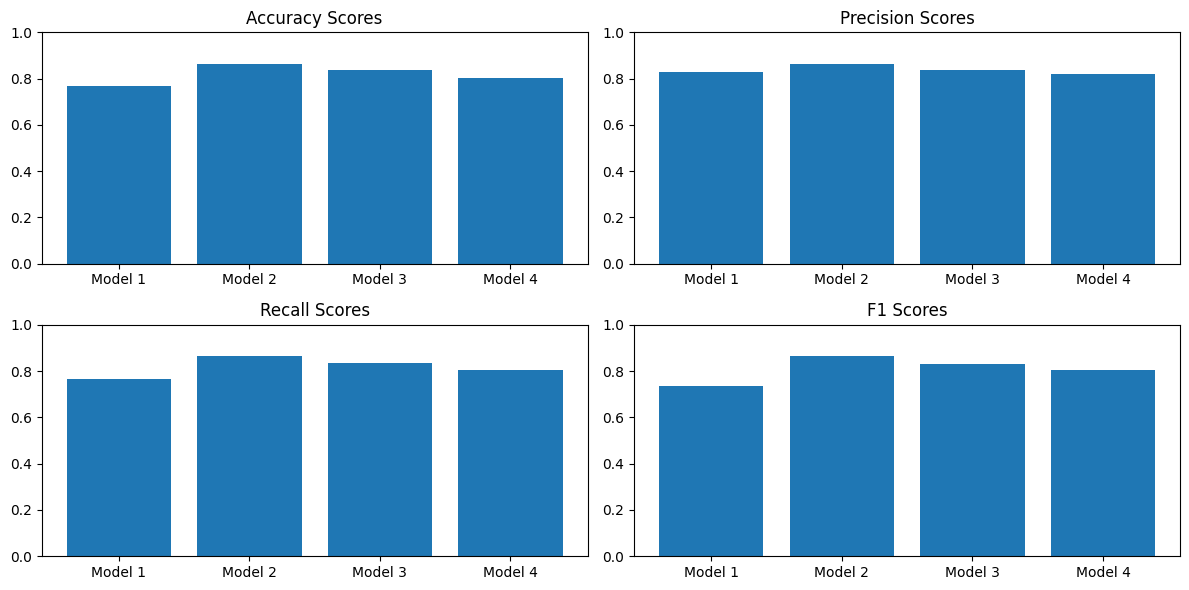

In [60]:
x_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.bar(x_labels, accuracy_scores)
plt.title('Accuracy Scores')
plt.ylim(0, 1)

plt.subplot(2, 2, 2)
plt.bar(x_labels, precision_scores)
plt.title('Precision Scores')
plt.ylim(0, 1)

plt.subplot(2, 2, 3)
plt.bar(x_labels, recall_scores)
plt.title('Recall Scores')
plt.ylim(0, 1)

plt.subplot(2, 2, 4)
plt.bar(x_labels, f1_scores)
plt.title('F1 Scores')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Calcul des métriques

In [61]:
precisions = [precision_score(y_true, y_pred_classes, average='weighted') for y_pred_classes in y_pred_classes_list]
recalls = [recall_score(y_true, y_pred_classes, average='weighted') for y_pred_classes in y_pred_classes_list]
f1_scores = [f1_score(y_true, y_pred_classes, average='weighted') for y_pred_classes in y_pred_classes_list]

# Création des graphiques pour visualiser les résultats

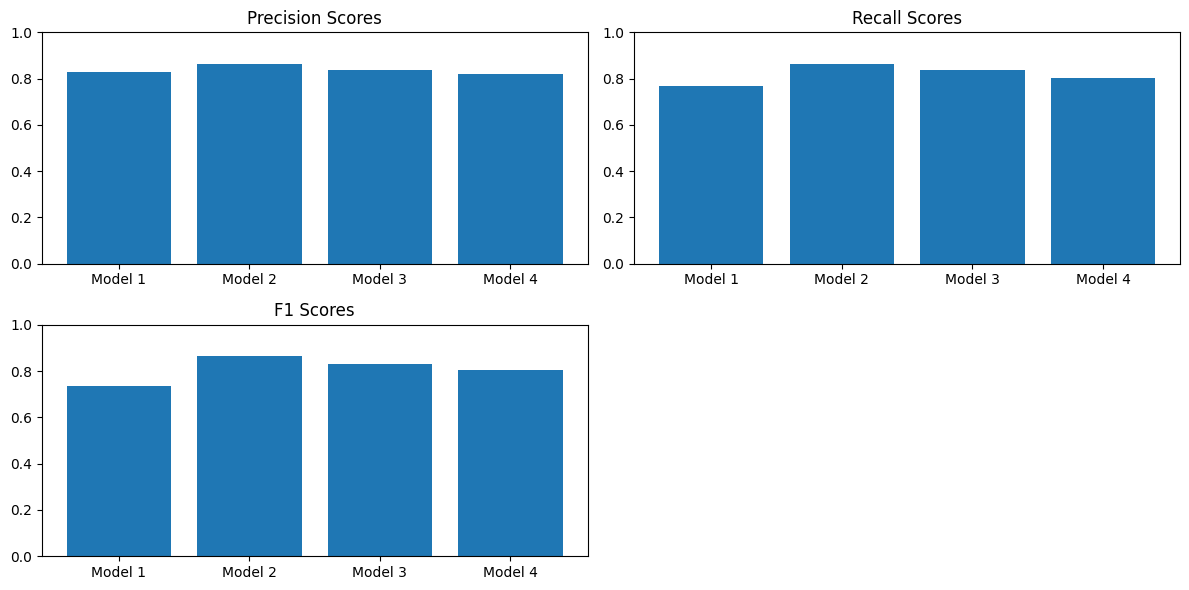

In [63]:
x_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.bar(x_labels, precisions)
plt.title('Precision Scores')
plt.ylim(0, 1)

plt.subplot(2, 2, 2)
plt.bar(x_labels, recalls)
plt.title('Recall Scores')
plt.ylim(0, 1)

plt.subplot(2, 2, 3)
plt.bar(x_labels, f1_scores)
plt.title('F1 Scores')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## Comparaison des précisions de test

In [65]:
test_accuracies = []

for i, model in enumerate(models):
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=32,
        color_mode=color_modes[i],  # Assurez-vous d'avoir défini la liste color_modes en fonction de vos modèles
        class_mode='categorical'
    )
    test_loss, test_acc = model.evaluate(test_generator)
    test_accuracies.append(test_acc)
    print(f"Test Accuracy for Model {i + 1}: {test_acc}")

best_model_index = np.argmax(test_accuracies)
print(f"\nThe best model is Model {best_model_index + 1} with a test accuracy of {test_accuracies[best_model_index]}")

Found 624 images belonging to 2 classes.
20/20 [==============================] - 6s 270ms/step - loss: 1.5522 - accuracy: 0.7676
Test Accuracy for Model 1: 0.7676281929016113
Found 624 images belonging to 2 classes.
20/20 [==============================] - 7s 330ms/step - loss: 0.7647 - accuracy: 0.8638
Test Accuracy for Model 2: 0.8637820482254028
Found 624 images belonging to 2 classes.
20/20 [==============================] - 33s 2s/step - loss: 0.9099 - accuracy: 0.8365
Test Accuracy for Model 3: 0.8365384340286255
Found 624 images belonging to 2 classes.
20/20 [==============================] - 3s 145ms/step - loss: 1.6714 - accuracy: 0.8029
Test Accuracy for Model 4: 0.8028846383094788

The best model is Model 2 with a test accuracy of 0.8637820482254028


## Comparaison des rapports de classification et des matrices de confusion

20/20 [==============================] - 7s 344ms/step
Classification Report for Model 1:
              precision    recall  f1-score   support

      NORMAL       0.34      0.13      0.19       234
   PNEUMONIA       0.62      0.85      0.72       390

    accuracy                           0.58       624
   macro avg       0.48      0.49      0.45       624
weighted avg       0.51      0.58      0.52       624



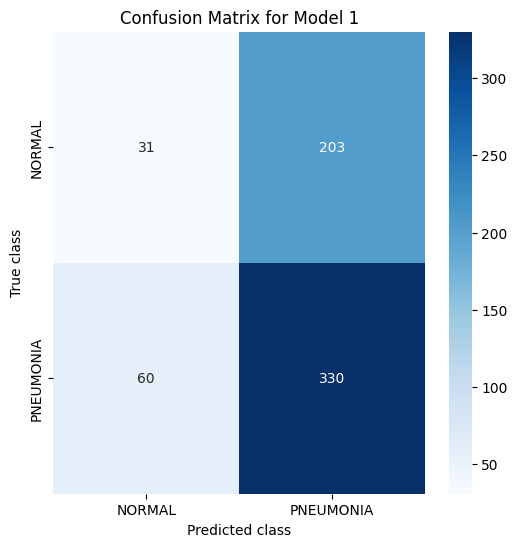

20/20 [==============================] - 6s 309ms/step
Classification Report for Model 2:
              precision    recall  f1-score   support

      NORMAL       0.38      0.40      0.39       234
   PNEUMONIA       0.63      0.62      0.62       390

    accuracy                           0.53       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.53      0.54       624



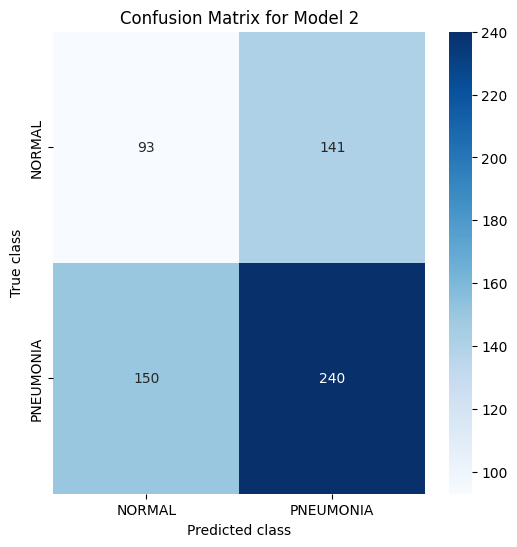

20/20 [==============================] - 32s 2s/step
Classification Report for Model 3:
              precision    recall  f1-score   support

      NORMAL       0.37      0.29      0.33       234
   PNEUMONIA       0.62      0.70      0.66       390

    accuracy                           0.55       624
   macro avg       0.50      0.50      0.49       624
weighted avg       0.53      0.55      0.54       624



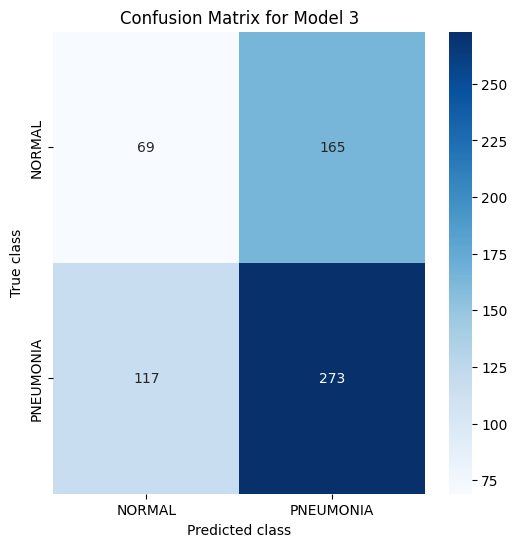

20/20 [==============================] - 3s 156ms/step
Classification Report for Model 4:
              precision    recall  f1-score   support

      NORMAL       0.35      0.44      0.39       234
   PNEUMONIA       0.60      0.52      0.56       390

    accuracy                           0.49       624
   macro avg       0.48      0.48      0.47       624
weighted avg       0.51      0.49      0.49       624



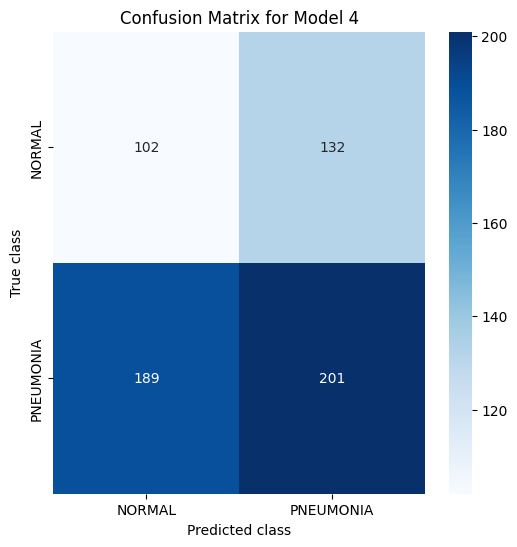

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Supposons que vous ayez deux classes: 'NORMAL' et 'PNEUMONIA'
class_names = ['NORMAL', 'PNEUMONIA']

for i, model in enumerate(models):
    # Générer les prédictions pour les images de test
    test_generator.reset()  # Assurez-vous de réinitialiser le générateur avant de faire des prédictions
    y_pred = model.predict(test_generator, steps=test_generator.samples//test_generator.batch_size+1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Générer le rapport de classification
    print(f"Classification Report for Model {i+1}:")
    print(classification_report(test_generator.classes, y_pred_classes, target_names=class_names))
    
    # Générer la matrice de confusion
    cm = confusion_matrix(test_generator.classes, y_pred_classes)
    
    # Afficher la matrice de confusion comme un heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title(f'Confusion Matrix for Model {i+1}')
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.show()